In [1]:
!  pip install kaggle

In [2]:
from google.colab import files

# Upload your kaggle.json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"essamkunjan","key":"a1b47627183233417fe57c5c83e8f986"}'}

In [3]:
!mkdir -p ~/.kaggle
!mkdir -p ~/.raggle
!ls -a /root/
!mv kaggle.json /root/.kaggle/

.   .bashrc  .config   .jupyter  .keras		.local	.profile  .tmux.conf
..  .cache   .ipython  .kaggle	 .launchpadlib	.npm	.raggle   .wget-hsts


In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

100% 345M/346M [00:04<00:00, 107MB/s] 
100% 346M/346M [00:04<00:00, 77.1MB/s]


In [5]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile('/content/intel-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Import Packages

In [6]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,MaxPooling2D,Conv2DTranspose,Activation, Input,concatenate
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Loading Dataset using Image Data Generator

In [8]:
img_size=150
batch_size=32

train='/content/seg_train/seg_train'
test='/content/seg_test/seg_test'

datagen=ImageDataGenerator(rescale=1/255.,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           validation_split=0.15)

traindata=datagen.flow_from_directory(train,
                                       target_size=(img_size,img_size),
                                       batch_size=batch_size,
                                       shuffle=True,
                                       class_mode='categorical',
                                       subset='training')
testdata=datagen.flow_from_directory(test,
                                      shuffle=False,
                                      batch_size=batch_size,
                                      target_size=(img_size,img_size),
                                      class_mode="categorical")

valdata=datagen.flow_from_directory(train,
                                    shuffle=False,
                                    batch_size=batch_size,
                                    target_size=(img_size,img_size),
                                    class_mode='categorical',
                                    subset='validation')

Found 11932 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.


Visualize the data

In [9]:
# Calculate the count of images per class for training dataset
train_class_counts = {label: 0 for label in traindata.class_indices.keys()}
for i in range(len(traindata)):
    batch_data, batch_labels = traindata[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = list(traindata.class_indices.keys())[class_idx]
        train_class_counts[class_label] += 1

# Calculate the count of images per class for testing dataset
test_class_counts = {label: 0 for label in testdata.class_indices.keys()}
for i in range(len(testdata)):
    batch_data, batch_labels = testdata[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = list(testdata.class_indices.keys())[class_idx]
        test_class_counts[class_label] += 1

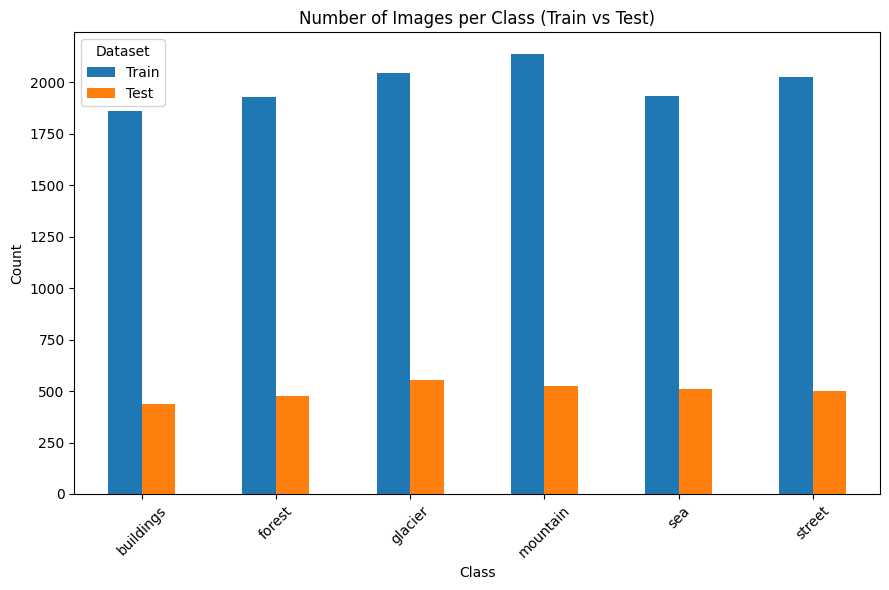

In [10]:
# Convert the dictionaries to pandas DataFrame
df = pd.DataFrame({'Train': train_class_counts, 'Test': test_class_counts})

# Plot the DataFrame as a bar plot
df.plot(kind='bar', figsize=(9, 6))
plt.title('Number of Images per Class (Train vs Test)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


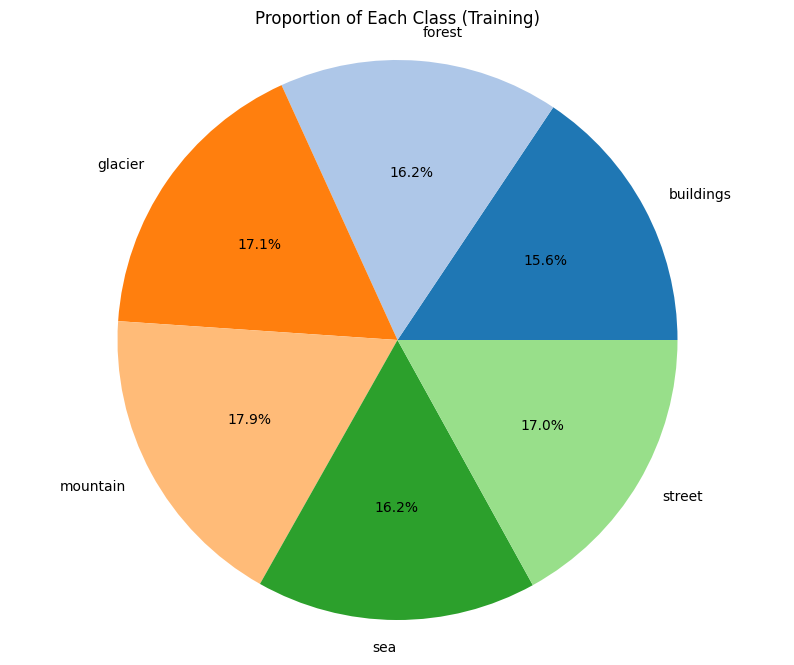

In [11]:
# # Calculate the total count of images for training dataset
total_train_images = sum(train_class_counts.values())

# # Calculate the proportion of each class for training dataset
train_class_proportions = {label: count / total_train_images for label, count in train_class_counts.items()}

# # Convert the dictionary to pandas Series
train_series = pd.Series(train_class_proportions)

# Plot the Series as a pie chart
plt.figure(figsize=(10, 8))
train_series.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.tab20.colors)
plt.title('Proportion of Each Class (Training)')
plt.ylabel('')
plt.axis('equal')
plt.show()


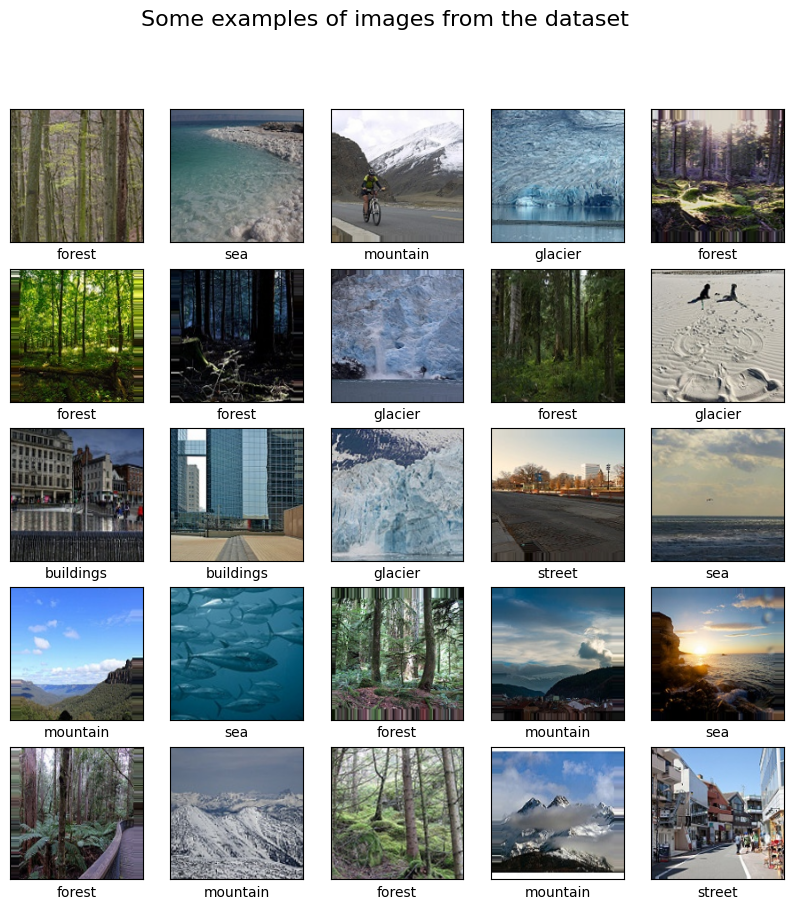

In [12]:
import numpy as np
import matplotlib.pyplot as plt
class_names = list(traindata.class_indices.keys())
# Function to display examples
def display_examples(class_names, images, labels, num_examples=25):
    """
    Display num_examples images from the images array with their corresponding labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images from the dataset", fontsize=16)
    for i in range(num_examples):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[np.argmax(labels[i])])
    plt.show()

# Assuming `traindata` is the train data generator
# Generate a batch of images and labels from the train data generator
images, labels = traindata.next()

# Assuming `class_names` is defined
# Display 25 examples from the images array with their corresponding labels
display_examples(class_names, images, labels)


our CNN model

In [13]:
img_size=150
model=Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape = (img_size,img_size,3), padding="same"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), activation='relu', padding="same"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3), activation='relu', padding="same"))
model.add(MaxPooling2D())

model.add(Conv2D(256,(3,3), activation='relu', padding="same", strides=2))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
# model.add(Dropout(.3))
model.add(Dense(6, activation="softmax"))

In [14]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 128)       0

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
filepath= "model_cnn.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

In [17]:
history = model.fit(traindata,epochs=15,validation_data=valdata,callbacks=[checkpoint,earlystopping])

Epoch 1/15
373/373 [==============================] - ETA: 0s - loss: 1.0292 - accuracy: 0.5937
Epoch 1: val_loss improved from inf to 0.83075, saving model to model_cnn.h5
373/373 [==============================] - 90s 223ms/step - loss: 1.0292 - accuracy: 0.5937 - val_loss: 0.8307 - val_accuracy: 0.6884


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/15
373/373 [==============================] - ETA: 0s - loss: 0.7345 - accuracy: 0.7264
Epoch 2: val_loss improved from 0.83075 to 0.63228, saving model to model_cnn.h5
373/373 [==============================] - 81s 218ms/step - loss: 0.7345 - accuracy: 0.7264 - val_loss: 0.6323 - val_accuracy: 0.7707
Epoch 3/15
373/373 [==============================] - ETA: 0s - loss: 0.6148 - accuracy: 0.7798
Epoch 3: val_loss improved from 0.63228 to 0.55703, saving model to model_cnn.h5
373/373 [==============================] - 79s 213ms/step - loss: 0.6148 - accuracy: 0.7798 - val_loss: 0.5570 - val_accuracy: 0.8107
Epoch 4/15
373/373 [==============================] - ETA: 0s - loss: 0.5305 - accuracy: 0.8060
Epoch 4: val_loss improved from 0.55703 to 0.52012, saving model to model_cnn.h5
373/373 [==============================] - 81s 217ms/step - loss: 0.5305 - accuracy: 0.8060 - val_loss: 0.5201 - val_accuracy: 0.8126
Epoch 5/15
373/373 [==============================] - ETA: 0s - los

 Plotting the Loss Curves

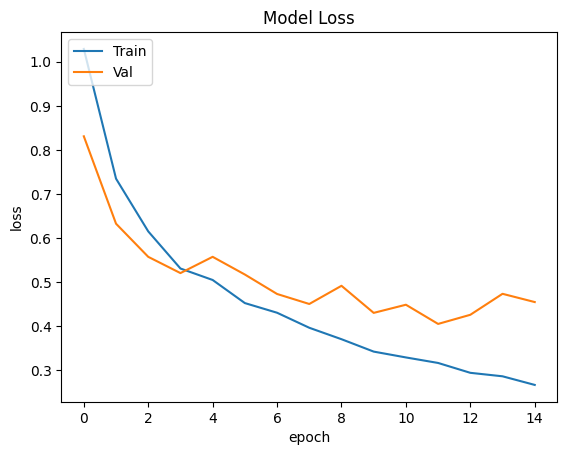

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

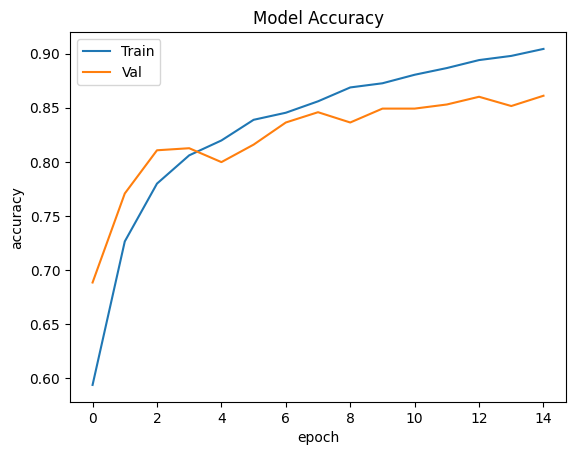

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Performance Testing on Testing Data

In [20]:
y_test = testdata.classes
y_pred = model.predict(testdata)
y_pred = np.argmax(y_pred,axis=1)

94/94 [==============================] - 18s 187ms/step


In [21]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Get the class names from the data generator
class_names = list(traindata.class_indices.keys())

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

   buildings       0.89      0.81      0.85       437
      forest       0.96      0.96      0.96       474
     glacier       0.77      0.89      0.82       553
    mountain       0.84      0.79      0.81       525
         sea       0.88      0.83      0.85       510
      street       0.86      0.89      0.88       501

    accuracy                           0.86      3000
   macro avg       0.87      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



In [22]:
# Print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)


Accuracy: 0.8606666666666667


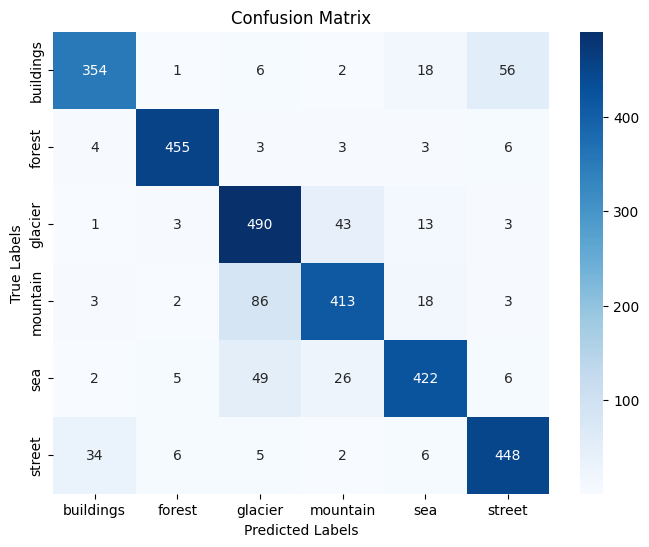

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Wrong Predictions made by model

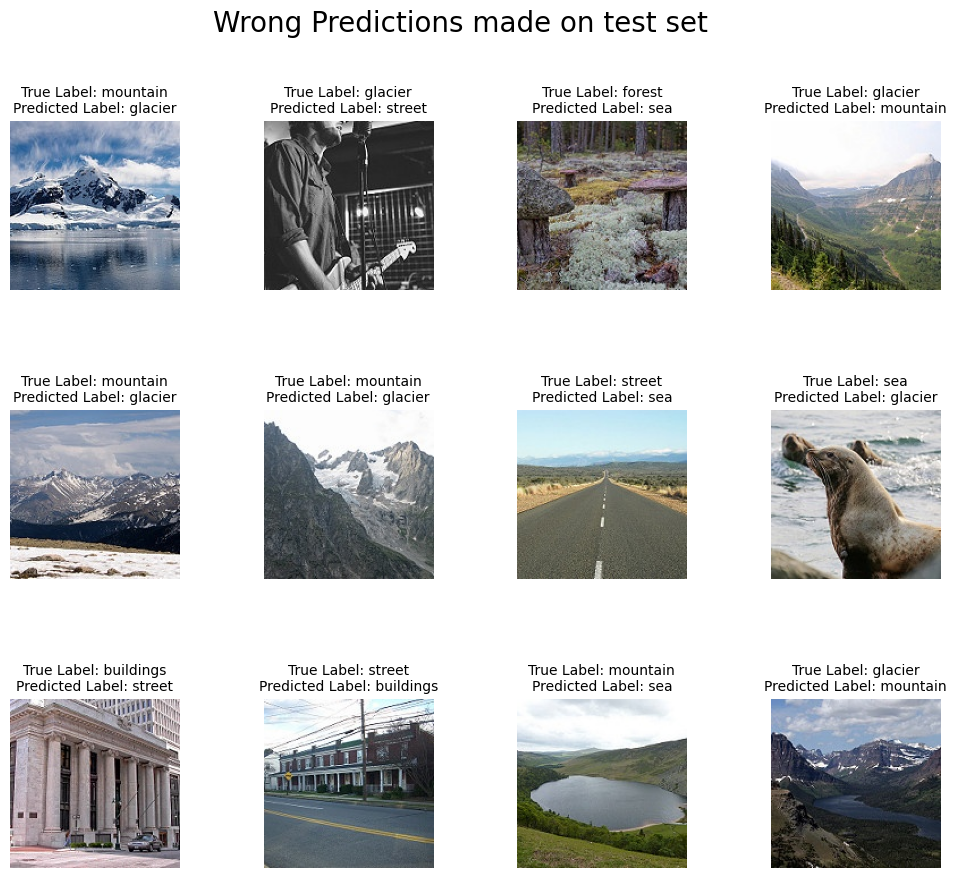

In [24]:
errors = (y_test - y_pred != 0)
y_true_errors = y_test[errors]
y_pred_errors = y_pred[errors]
test_images = testdata.filenames
test_img = np.asarray(test_images)[errors]

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
idx = 0

for i in range(3):
    for j in range(4):
        idx = np.random.randint(0, len(test_img))
        true_label = class_names[y_true_errors[idx]]
        predicted_label = class_names[y_pred_errors[idx]]
        ax[i, j].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}", fontsize=10)
        img_path = os.path.join(test, test_img[idx])
        img = plt.imread(img_path)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()
